### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) $-\frac{d}{da}L = 2(y_i - a(x_i))$

2) $-\frac{d}{da}L = y_iexp(-a(x_i)y_i)$

3) $-\frac{d}{da}L = \frac{y_i exp(-a(x_i)y_i)}{1 + exp(-a(x_i)y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [135]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, my_n_estimators=100, 
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.params = args
        self.kwparams = kwargs
        self.preds = None
        if loss == 'MSE':
            self.__antigr = self.__mse
        elif loss == 'exponential':
            self.__antigr = self.__exp
        elif loss == 'logistic':
            self.__antigr = self.__log
        self.models = []
        self.features = []
    
    def __mse(self, y, preds):
        return 2 * (y - preds)
    
    def __exp(self, y, preds):
        return y * np.exp(-y * preds)
    
    def __log(self, y, preds):
        return y * np.exp(-y * preds) / (1 + np.exp(-y * preds))
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model is None:
            self.init_model = None
            self.preds = np.ones(X.shape[0]) / X.shape[0]
        else:
            model = init_model()
            model.fit(X, y)
            self.init_model = model
            self.preds = model.predict(X)
            self.preds = self.preds.astype(float)
        
        for i in range(self.n_estimators):
            features_num = int(self.colsample * X.shape[1])
            features = np.random.randint(low=0, high=X.shape[1], size=features_num)
            objects_num = int(self.subsample * X.shape[0])
            objects = np.random.randint(low=0, high=X.shape[0], size=objects_num)
            model = base_model(*self.params, **self.kwparams)
            cur_X = X[objects]
            model.fit(cur_X[:, features], self.__antigr(y[objects], self.preds[objects]))
            self.preds += self.learning_rate * model.predict(X[:, features])
            self.models.append(model)
            self.features.append(features)
        
    def predict(self, X):
        # Ваш код здесь
        preds = None
        if self.init_model is None:
            preds = np.ones(X.shape[0]) / X.shape[0]
        else:
            preds = self.init_model.predict(X).astype(float)
        for i in range(len(self.models)):
            preds += self.learning_rate * self.models[i].predict(X[:, self.features[i]])
        return np.around(preds)

In [65]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [66]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [67]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [68]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [69]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [79]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [76]:
score = []
for n_estimators in [10, 20, 50, 70, 100, 150, 200]:
    cur_score = []
    for train, val in KFold(n_splits=5, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators)
        my_clf.fit(X[train], y[train])
        cur_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(cur_score))
    score.append(np.mean(cur_score))

0.8531007751937985
0.8709786821705426
0.8661337209302324
0.878391472868217
0.8700581395348836
0.8688468992248062
0.8755813953488373


NameError: name 'plt' is not defined

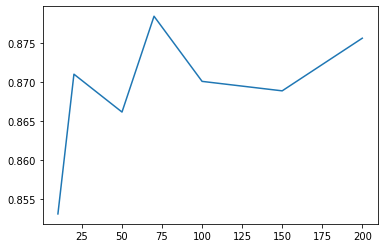

In [80]:
plt.plot([10, 20, 50, 70, 100, 150, 200], score)
plt.show()

In [81]:
n_estimators = 70

In [82]:
score = []
for loss in ['MSE', 'exponential', 'logistic']:
    cur_score = []
    for train, val in KFold(n_splits=5, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators, loss=loss)
        my_clf.fit(X[train], y[train])
        cur_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(cur_score))
    score.append(np.mean(cur_score))
score

0.8679263565891473
0.5090116279069767
0.5993217054263565


[0.8679263565891473, 0.5090116279069767, 0.5993217054263565]

In [83]:
loss = 'MSE'

In [87]:
score = []
for learning_rate in [0.01, 0.05, 0.1, 0.2, 0.5, 0.7]:
    cur_score = []
    for train, val in KFold(n_splits=5, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators, loss=loss, 
                                              learning_rate=learning_rate)
        my_clf.fit(X[train], y[train])
        cur_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(cur_score))
    score.append(np.mean(cur_score))

0.8652616279069768
0.8875
0.8659883720930232
0.8376937984496123
0.6433139534883721
0.0001937984496124031


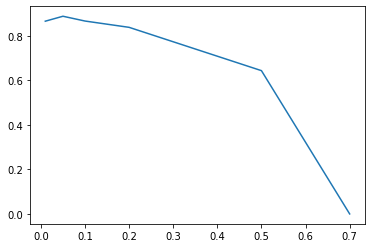

In [88]:
plt.plot([0.01, 0.05, 0.1, 0.2, 0.5, 0.7], score)
plt.show()

In [90]:
learning_rate = 0.05

In [92]:
score = []
for colsample in [0.2, 0.3, 0.5, 0.7, 1.0]:
    cur_score = []
    for train, val in KFold(n_splits=5, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators, loss=loss, 
                                        learning_rate=learning_rate, colsample=colsample)
        my_clf.fit(X[train], y[train])
        cur_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(cur_score))
    score.append(np.mean(cur_score))
score

0.7181201550387597
0.8143410852713178
0.8809108527131784
0.8773740310077519
0.886627906976744


[0.7181201550387597,
 0.8143410852713178,
 0.8809108527131784,
 0.8773740310077519,
 0.886627906976744]

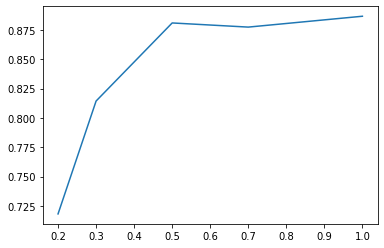

In [93]:
plt.plot([0.2, 0.3, 0.5, 0.7, 1.0], score)
plt.show()

In [94]:
colsample = 1.0

In [96]:
score = []
for subsample in [0.2, 0.3, 0.5, 0.7, 1.0]:
    cur_score = []
    for train, val in KFold(n_splits=5, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
        my_clf.fit(X[train], y[train])
        cur_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(cur_score))
    score.append(np.mean(cur_score))
score

0.8733527131782945
0.8786337209302324
0.8879360465116278
0.8881782945736434
0.8886143410852713


[0.8733527131782945,
 0.8786337209302324,
 0.8879360465116278,
 0.8881782945736434,
 0.8886143410852713]

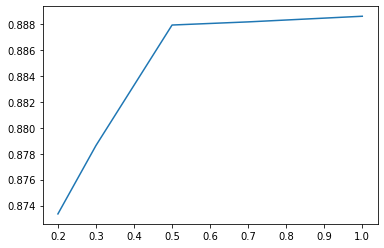

In [97]:
plt.plot([0.2, 0.3, 0.5, 0.7, 1.0], score)
plt.show()

In [98]:
subsample = 1.0

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [89]:
from sklearn.ensemble import RandomForestRegressor

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
    learning_rate=learning_rate, colsample=colsample, subsample=subsample, n_estimators=5)
my_clf.fit(X[train], y[train], base_model=RandomForestRegressor)
accuracy_score(y_test, my_clf.predict(X_test))

0.978359173126615

In [144]:
N = 100
preds = np.zeros(y_test.shape)
for i in range(N):
    objects = np.random.randint(low=0, high=X_train.shape[0], size=X_train.shape[0] // N)
    my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
    my_clf.fit(X_train[objects], y_train[objects])
    preds += my_clf.predict(X_test)
accuracy_score(y_test, (preds / N) >= 0.5)

0.8470607235142119

RandomForestRegressor позволил значительно улучшить качество классификатора, потому что эта модель очень хорошо подстраивается под данные, а BagBoo почти не отличается своим accuracy от результатов одного классификатора, потому что мы брали в качестве базовых моделей фактически одну и ту же модель, только настроенную на других данных

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [136]:
from sklearn.neighbors import KNeighborsClassifier

my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=KNeighborsClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.6437338501291989

In [137]:
from sklearn.tree import DecisionTreeClassifier

my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=DecisionTreeClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.8297803617571059

In [138]:
from sklearn.linear_model import SGDClassifier

my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=SGDClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.8704780361757106

In [139]:
from sklearn.svm import LinearSVC

my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=LinearSVC)
accuracy_score(y_test, my_clf.predict(X_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/base.py:928: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8443152454780362

In [142]:
from sklearn.linear_model import LinearRegression

my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=LinearRegression)
accuracy_score(y_test, my_clf.predict(X_test))

0.8854974160206718

In [143]:
my_clf = MyGradientBoostingClassifier(my_n_estimators=n_estimators, loss=loss, 
                    learning_rate=learning_rate, colsample=colsample, subsample=subsample)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
accuracy_score(y_test, my_clf.predict(X_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/forest.py:244: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  warn("The default value of n_estimators will change from "


0.8716085271317829

От модели, которой мы инициализируем бустинг, зависит качество результата (это видно на примере с КНН). Какие-то модели лучше описывают данные, поэтому у Линейной регрессии или RandomForest результаты выше

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

